In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from PlotTools import plot_tools as PT

from SoilTools import Hutton as HU
from SoilTools import Hollis as HO

from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (12,12)


In [2]:
CM=PT.custom_div_cmap(numcolors=15,name='grad',colors=['blue','orange','yellow'])

In [3]:
SOIL_DIR='/prj/GREENHOUSE/SOIL_PROPERTIES/datasets/'
EnW_file=SOIL_DIR+'England_Wales_Soil_Data/LDE16_12_SRUC_Tarsitano/' + \
            'EnW_Soil_WeightedCompositionProperties_CHESSgrid.nc'

Scot_file=SOIL_DIR+'Scotland_Soil_Data/' + \
            'Scot_Soil_WeightedCompositionProperties_CHESSgrid.nc'

#COMP_appendfile=SOIL_DIR+'Merged_Soil_WeightedComposition_CHESSgrid.nc'

CHESS_landcover_file='/users/eow/edwcom/CHESS/chess_landcover_2000.nc'

fill_value=-9999.
Soil_Layer_Thick=np.array([0.1,0.25,0.65,2.0])   #(metres)
Soil_Layer_Depth=np.array([0.1,0.23,1.0,3.0]) #(metres)
nSD=len(Soil_Layer_Thick)


In [52]:
EnW_datadict={}
EnWinf=nc.Dataset(EnW_file,'r')
for var in ['sand','silt','clay','org_carb','Bulk_Density']:
    #EnW_datadict[var]=EnWinf.variables[var][1:,:].flatten()
    EnW_datadict[var]=EnWinf.variables[var][0,:].flatten()
    #print(var)

#soil_depth=np.zeros_like(EnWinf.variables['sand'][1:,:].squeeze())
#soil_depth=np.zeros_like(EnWinf.variables['sand'][0,:].squeeze())+Soil_Layer_Depth[0]

#for iSD in range(1,nSD):
#    soil_depth[iSD-1,:]=Soil_Layer_Depth[iSD]
#for iSD in range(nSD):
#    soil_depth[iSD,:]=Soil_Layer_Depth[iSD]

EnWinf.close()

# Normalise sand silt clay fractions
TOTAL_comp=EnW_datadict['sand']+EnW_datadict['silt']+EnW_datadict['clay']
for var in EnW_datadict:
    EnW_datadict[var][TOTAL_comp<90.]=EnW_datadict[var].fill_value
    EnW_datadict[var]=np.ma.masked_equal(EnW_datadict[var],EnW_datadict[var].fill_value)
    EnW_datadict[var]=EnW_datadict[var]*(100./TOTAL_comp)

#    
#EnW_datadict['soil_depth']=np.ma.masked_array(soil_depth.flatten(),mask=EnW_datadict['sand'].mask)

In [53]:
BULK_DENSITY_HUTTON=HU.bulk_density(EnW_datadict['org_carb'], \
                                    EnW_datadict['clay'],     \
                                    EnW_datadict['silt']      )

In [54]:
BULK_DENSITY_HOLLIS=HO.Cult_TopSoil_BD(EnW_datadict['org_carb'], \
                                       EnW_datadict['sand'],     \
                                       EnW_datadict['clay']      )

In [55]:
Scot_datadict={}
Scotinf=nc.Dataset(Scot_file,'r')
for var in ['sand','silt','clay','org_carb']:
    Scot_datadict[var]=Scotinf.variables[var][0,:]
Scotinf.close()


In [56]:

data=pd.DataFrame(EnW_datadict)
data=data.dropna(0)
data['log_org_carb']=np.log(data['org_carb'])
data['exp_org_carb']=np.exp(data['org_carb'])
data['sq_org_carb']=data['org_carb']**2
data['cu_org_carb']=data['org_carb']**3
#data['sq_soil_depth']=data['soil_depth']**2
#data['sqrt_soil_depth']=data['soil_depth']**0.5
#data['log_soil_depth']=np.log(data['soil_depth'])
#data['exp_soil_depth']=np.exp(data['soil_depth'])


In [57]:
#soil_depth.shape

In [58]:
print(EnW_datadict['Bulk_Density'].shape)
print(np.min(EnW_datadict['Bulk_Density']))



(693392,)
0.28


In [68]:

model=ols("Bulk_Density ~ log_org_carb",data).fit()
#model=ols("Bulk_Density ~ log_org_carb + sand + clay + silt",data).fit()
# +  cu_org_carb + forth_org_carb
#model=ols("Bulk_Density ~ org_carb",data).fit()
#model=ols("Bulk_Density ~ sand + silt + log_org_carb + soil_depth +org_carb",data).fit()

In [69]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Bulk_Density   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 1.432e+06
Date:                Wed, 07 Sep 2016   Prob (F-statistic):               0.00
Time:                        15:48:42   Log-Likelihood:             2.7773e+05
No. Observations:              150120   AIC:                        -5.555e+05
Df Residuals:                  150118   BIC:                        -5.554e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        1.5011      0.000   3871.764   

In [70]:
Bulk_Density_Model =  model.params['Intercept'] #(data['Bulk_Density'].copy())*0.0
for param in model.params.index:
    
    if param!='Intercept':
        print( param, '*',model.params[param], data[param].mean(), data[param].max())
        Bulk_Density_Model+= data[param]*model.params[param]


log_org_carb * -0.312878755415 1.43469 3.55535


In [71]:
#print(Bulk_Density_Model)

(-0.1, 2.0)

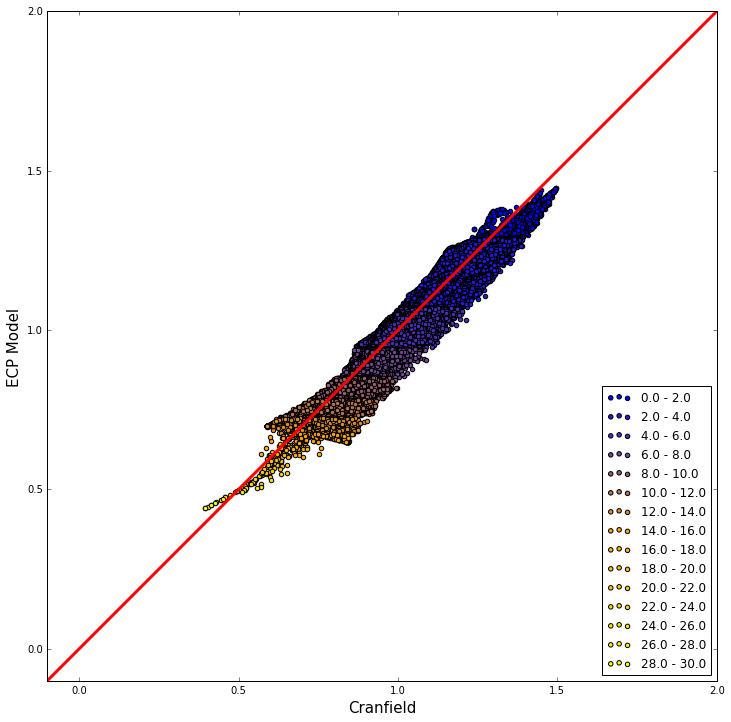

In [72]:
param='org_carb'
interval=2
data1,name1=data['Bulk_Density'],'Cranfield'
data2,name2=Bulk_Density_Model,'ECP Model'

for i in range(15):#,0,-1):
    index=(data[param]>(float(i)*interval-0.01))&\
          (data[param]<((float(i)*interval)+interval-0.01))
    plt.scatter(data1[index],data2[index],c=CM(i),\
                label=str(float(i)*interval)+' - '+str((float(i)*interval)+interval) )

#plt.scatter(data1,data2,c=CM(i))

plt.legend(loc='lower right')
plt.plot([-0.5,2],[-0.5,2],c='r',lw=3)
plt.xlabel(name1,fontsize=15)
plt.ylabel(name2,fontsize=15)
plt.ylim([-0.1,2.])
plt.xlim([-0.1,2.])

(-0.1, 2.0)

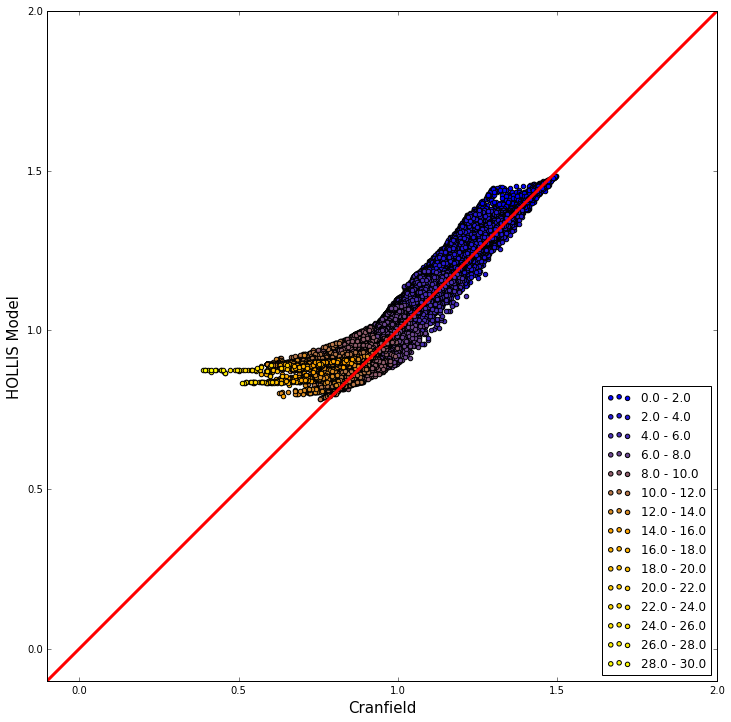

In [64]:
param='org_carb'
interval=2.
data1,name1=EnW_datadict['Bulk_Density'],'Cranfield'
data2,name2=BULK_DENSITY_HOLLIS,'HOLLIS Model'

for i in range(15):
    index=(EnW_datadict[param]>(float(i)*interval))&\
          (EnW_datadict[param]<((float(i)*interval)+interval))
    plt.scatter(data1[index],data2[index],c=CM(i),\
                label=str(float(i)*interval)+' - '+str((float(i)*interval)+interval) )

plt.legend(loc='lower right')
plt.plot([-0.5,2],[-0.5,2],c='r',lw=3)
plt.xlabel(name1,fontsize=15)
plt.ylabel(name2,fontsize=15)
plt.ylim([-0.1,2.])
plt.xlim([-0.1,2.])

(-0.1, 2)

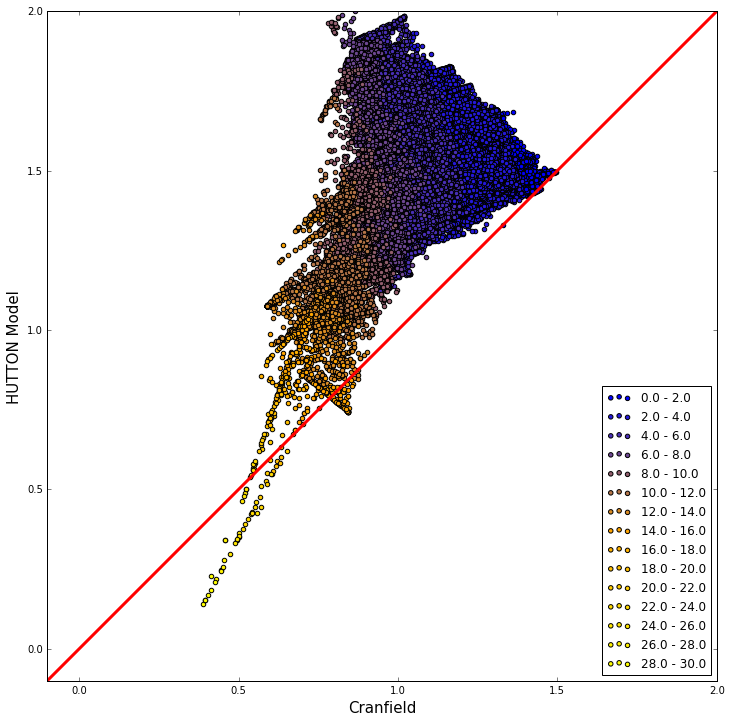

In [65]:
param='org_carb'
interval=2.
data1,name1=EnW_datadict['Bulk_Density'],'Cranfield'
data2,name2=BULK_DENSITY_HUTTON,'HUTTON Model'

for i in range(15):
    index=(EnW_datadict[param]>(float(i)*interval))&\
          (EnW_datadict[param]<((float(i)*interval)+interval))
    plt.scatter(data1[index],data2[index],c=CM(i),\
                label=str(float(i)*interval)+' - '+str((float(i)*interval)+interval) )

plt.legend(loc='lower right')
plt.plot([-0.5,2],[-0.5,2],c='r',lw=3)
plt.xlabel(name1,fontsize=15)
plt.ylabel(name2,fontsize=15)
plt.ylim([-0.1,2])
plt.xlim([-0.1,2])

In [18]:
# Use model parameters to calculate Scotish Bulk Density
Scot_datadict['sq_org_carb']=Scot_datadict['org_carb']**2
Scot_datadict['log_org_carb']=np.log(Scot_datadict['org_carb'])

Scot_datadict['Bulk_Density'] = model.params['Intercept'] 
for param in model.params.index:
    if param!='Intercept':
        Scot_datadict['Bulk_Density']+= Scot_datadict[param]*model.params[param]
    


In [ ]:
print(Scot_datadict['Bulk_Density'].shape)
print(np.min(Scot_datadict['Bulk_Density']))

hist_data=Scot_datadict['Bulk_Density']
plt.hist(hist_data[hist_data.mask==False],bins=50) #np.arange(0,15.6,1.))
plt.show()

plt.scatter(Scot_datadict['Bulk_Density'],Scot_datadict['org_carb'])
plt.ylabel('org_carb')
plt.xlabel('Bulk_Density')
plt.show()

plt.imshow(Scot_datadict['Bulk_Density'],origin='bottom')
plt.colorbar()

In [ ]:
EnWinf=nc.Dataset(EnW_file,'r')
Scotinf=nc.Dataset(Scot_file,'a')

outvar=Scotinf.createVariable()

Scotinf.close()
